<a href="https://colab.research.google.com/github/kevinMGII/Grupo7-Practica2/blob/main/02_Clustering_gr_81_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SEGUNDA PRÁCTICA**. Clustering de semillas.
Aprendizaje Automático 2024/2025

Grupo 7. Miembros:

*   *Bárbara Sánchez Moratalla, 100495857.*
*   *Kevin Medina García, 100495893.*

---

El objetivo de esta segunda práctica es aplicar técnicas de clustering para detectar agrupaciones significativas en un conjunto de datos de semillas. Se trata de aprendizaje no supervisado, por lo que no utilizaremos la variable de respuesta. Además, exploreremos métodos de escalado, así como reducción de dimensionalidad (PCA) y técnicas de clustering (K-Means, jerárquico y DBSCAN).


### **1. CARGA Y VISUALIZACIÓN DE LOS DATOS**

Comenzamos cargando el conjunto de datos `semillas.csv` y mostrando las primeras filas del dataset.

- Lectura de datos y fijación de la semilla

In [1]:
import pandas as pd

dataframe_semillas = pd.read_csv('semillas.csv')                                # Leemos el archivo y lo almacenamos en un dataFrame
display(dataframe_semillas.head())                                              # Mostramos las primeras filas del dataframe

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


Cumpliendo las Consideraciones Generales de la práctica, establecemos una variable con el NIA de uno de los miembros del grupo y la utilizaremos para reproducibilidad de resultados.

In [2]:
NIA = 100495857                                                                 # Definimos NIA para reproducibilidad

---

### **2. ELECCIÓN DEL ESCALADOR MÁS APROPIADO**

Para elegir el escalador maś apropiado, evaluaremos tres métodos diferentes de escalado (MinMaxScaler, RobustScaler y StandardScaler) tanto visual como analíticamente.

Comenzamos aplicando PCA para reducir los datos a dos dimensiones, lo que nos permitirá observar cómo se distribuyen y agrupan los datos tras el escalado. Seguidamente dibujaremos los resultados a través de plots, para así tener una visualización clara del efecto de cada método. Con el propósito de realizar una evaluación analítica de la elección, no obstante, calcularemos la varianza explicada de cada método y escogeremos como más apropiado al método que presente mayor varianza.

**Carga de librerías necesarias**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

**Elección del escalador**

Comparamos visual y analíticamente los métodos de escalado: MinMaxScaler, StandardScaler y RobustScaler. Para ello, escalamos los atributos excluyendo la variable objetivo, aplicamos PCA a los datos para graficarlos en 2 dimensiones y gráficamos los puntos resultantes



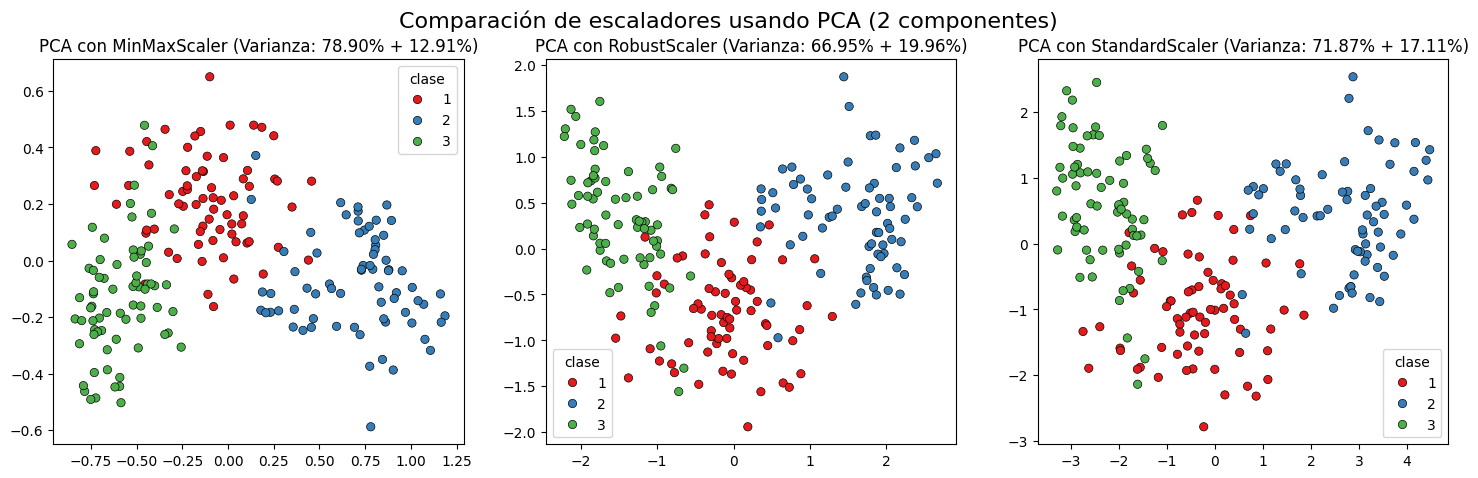

In [4]:
escaladores = {                                                                 # Definimos los escaladores a probar
    'MinMaxScaler': MinMaxScaler(),                                             # Escalador que normaliza los datos en el rango [0, 1]
    'RobustScaler': RobustScaler(),                                             # Escalador robusto que utiliza la mediana y el IQR para minimizar la influencia de outliers
    'StandardScaler': StandardScaler()                                          # Escalador que estandariza los datos restando la media y dividiendo por la desviación estándar
}

figura_completa, ejes = plt.subplots(1, 3, figsize=(18, 5))                     # Preparamos una figura para comparar los PCA de cada escalado

objetivo = dataframe_semillas['clase']                                          # Obtenemos la variable objetivo
atributos = dataframe_semillas.drop(columns=['clase'])                          # Obtenemos los atributos (X) del dataset

contador = 0                                                                    # Inicializamos un contador para recorrer cada uno de los subplots

for elem in escaladores:                                                        # Recorremos cada uno de los escaladores

    escalador_actual = escaladores[elem]                                        # Obtenemos el escalador actual
    X_escalado = escalador_actual.fit_transform(atributos)                      # Escalamos los datos

    modelo_pca = PCA(n_components=2, random_state=NIA)                          # Definimos el PCA con 2 componentes para reproducibilidad
    X_pca = modelo_pca.fit_transform(X_escalado)                                # Aplicamos PCA a los datos escalados
    explained_variance = modelo_pca.explained_variance_ratio_                   # Obtenemos la varianza explicada de cada componente

    eje_actual = ejes[contador]                                                 # Obtenemos el eje correspondiente

    sns.scatterplot(                                                            # Graficamos los datos en el eje actual
        x=X_pca[:, 0],                                                          # Primer componente principal en el eje X
        y=X_pca[:, 1],                                                          # Segundo componente principal en el eje Y
        hue=objetivo,                                                           # Coloreamos según la variable objetivo 'clase'
        palette= 'Set1',                                                        # Establecemos el mapa de colores a 'Set1'
        edgecolor='black',                                                      # Establecemos el color del borde de cada punto a negro
        ax=eje_actual                                                           # Indicamos en cuál subplot se dibuja
    )

    titulo = "PCA con {} (Varianza: {:.2%} + {:.2%})".format(elem, explained_variance[0], explained_variance[1])      # Establecemos el título del subplot
    eje_actual.set_title(titulo)                                                                                      # Asignamos el título al subplot

    contador += 1                                                               # Pasamos al siguiente subplot

plt.suptitle("Comparación de escaladores usando PCA (2 componentes)", fontsize=16)  # Título general de la figura
plt.show()                                                                          # Mostramos la figura con todos los subplots

Como podemos observar en las gráficas, MinMaxScaler consigue la representación en dos dimensiones en la que se aprecia una mayor separación y agrupación de las clases, ya que normaliza los datos en un rango uniforme [0,1].

Además, la evaluación analítica con la varianza explicada muestra un mayor porcentaje en las dos primeras componentes, lo que respalda nuestra elección de MinMaxScaler como el escalador más apropiado para el problema.

### **3. CLUSTERING USANDO LOS DATOS TRANSFORMADOS (2D)**

Elegido MinMaxScaler como el escalador más apropiado, aplicaremos técnicas de clustering con la representación en dos dimensiones mediante PCA y MinMaxScaler.

El clustering persigue el objetivo de encontrar agrupaciones significativas en los datos ante la ausencia de la variable de respuesta. Implementaremos y compararemos las siguientes técnicas de clustering:

- **K-Means**: encontramos el número óptimo de clusters utilizando el método del codo y el índice de silhouette.
- **Clustering jerárquico**: aplicamos técnicas aglomerativas con sklearn, y representamos los resultados a través de dendogramas. Para ello, usaremos funciones de linkage: ward, average y complete.
- **DBSCAN**: identificamos agrupaciones basadas en densidad, y detectamos posibles outliers en los datos. Es necesario ajustar hiperparámetros como: minpts y eps.



**Preparamos los datos con MinMaxScaler y PCA**

Realizamos una transformación de los datos utilizando un Pipeline para combinar el escalado con MinMaxScaler y PCA para reducir la dimensionalidad a 2 componentes.

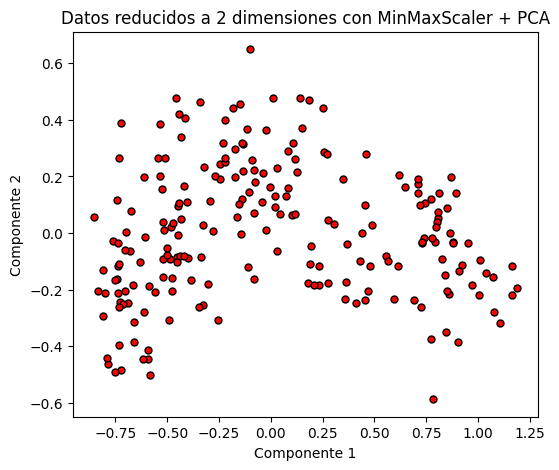

In [5]:
from sklearn.pipeline import Pipeline                                           # Importamos el Pipeline

pipe = Pipeline([                                                               # Creamos un Pipeline
    ('scaler', MinMaxScaler()),                                                 # Primer paso: elegimos el mejor escalador
    ('pca', PCA(n_components=2, random_state=NIA))                              # Segundo paso: aplicamos PCA para reducir la dimensionalidad a 2 componentes; se utiliza NIA como semilla para reproducibilidad
])

X_2d = pipe.fit_transform(atributos)                                            # Entrenamos el Pipeline a los datos 'atributos' y transformamos dichos datos a 2 dimensiones; se guarda el resultado en X_2d

plt.figure(figsize=(6, 5))                                                      # Creamos una figura para visualizar el gráfico
plt.scatter(X_2d[:, 0],                                                         # Usamos la primera columna de X_2d (primer componente principal) para el eje X
            X_2d[:, 1],                                                         # Usamos la segunda columna de X_2d (segundo componente principal) para el eje Y
            s=25,                                                               # Establecemos el tamaño de cada punto a 25
            color='red',                                                        # Establecemos el color de cada punto a rojo
            edgecolor='black'                                                   # Establecemos el color del borde de cada punto a negro
            )

plt.title("Datos reducidos a 2 dimensiones con MinMaxScaler + PCA")             # Asignamos un título al gráfico
plt.xlabel("Componente 1")                                                      # Asignamos un título al eje X
plt.ylabel("Componente 2")                                                      # Asignamos un título al eje Y
plt.show()                                                                      # Mostramos el gráfico en pantalla

**KMeans**

K-Means agrupa los datos en K clusters, minimizando la distancia entre cada punto y el centroide de su grupo. Asigna iterativamente los puntos al cluster más cercano y recalcula los centroides. Para determinar el número óptimo de clusters, emplearemos: Método del codo (Elbow Method) e índice silhouette.

- Método del codo

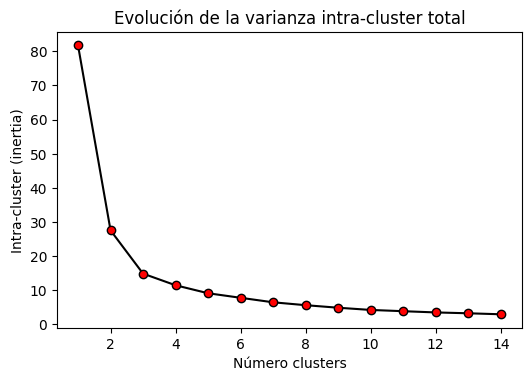

In [6]:
from sklearn.cluster import KMeans                                              # Importamos KMeans

range_n_clusters = range(1, 15)                                                 # Definimos un rango de clusters para probar
inertias = []                                                                   # Inicializamos una lista para almacenar las inercias

for n_clusters in range_n_clusters:                                             # Recorremos cada cluster
    modelo_kmeans = KMeans(                                                     # Definimos un modelo KMeans
                           n_clusters=n_clusters,                               # Creamos un modelo KMeans con el número de clusters actual
                           n_init=20,                                           # Ponemos 20 inicializaciones
                           random_state=NIA                                     # Fijamos la semilla para reproducibilidad
                           )
    modelo_kmeans.fit(X_2d)                                                     # Entrenamos el modelo con los datos en 2d (X_2d)
    inertias.append(modelo_kmeans.inertia_)                                     # Guardamos en la lista la inercia del modelo

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))                                 # Creamos una figura para visualizar el gráfico
ax.plot(
    range_n_clusters,                                                           # En el eje X el número de clusters
    inertias,                                                                   # Es la inercia correspondiente a cada k en el eje Y
    marker='o',                                                                 # Ponemos un marcador circular para destacar cada punto en la curva
    color='black',                                                              # Ponemos el color de la línea a negro
    markerfacecolor='red',                                                      # Rellenamos los puntos de rojo
    markeredgecolor='black'                                                     # Ponemos el borde de los puntos a negro
)

ax.set_title("Evolución de la varianza intra-cluster total")                    # Añadimos un título al gráfico
ax.set_xlabel('Número clusters')                                                # Etiquetamos el eje X indicando el número de clusters
ax.set_ylabel('Intra-cluster (inertia)');                                       # Etiquetamos el eje Y indicando la inercia

En las gráficas del método del codo, buscamos el punto donde la reducción de la inercia comienza a decrementar su valor de forma muy suave, es decir, se forma un codo.

Podemos observar como el valor óptimo es K=3, como ya suponíamos tras visualizar los datos, puesto que dividir los datos en más de 3 grupos no aporta tanta mejora.

- Índice silhouette

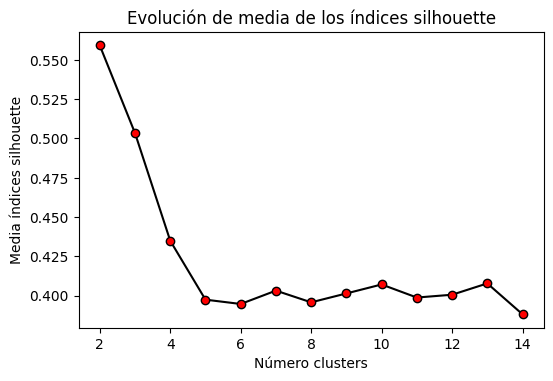

In [7]:
from sklearn.metrics import silhouette_score                                    # Importamos la función silhouette_score para evaluar la calidad de nuestros clusters

range_n_clusters = range(2, 15)                                                 # Definimos un rango de posibles números de clusters (desde 2 hasta 14) para probar distintas configuraciones
valores_medios_silhouette = []                                                  # Inicializamos una lista para almacenar los valores medios de silhouette para cada número de clusters

for n_clusters in range_n_clusters:                                             # Recorremos cada número de clusters
    modelo_kmeans = KMeans(                                                     # Definimos un modelo KMeans
                          n_clusters=n_clusters,                                # Establecemos el número de clusters actual
                          n_init=25,                                            # Ponemos 20 inicializaciones
                          random_state=NIA                                      # Fijamos la semilla para reproducibilidad
                          )
    cluster_labels = modelo_kmeans.fit_predict(X_2d)                            # Entrenamos el modelo y obtenemos las etiquetas de los clusters
    silhouette_avg = silhouette_score(X_2d, cluster_labels)                     # Calculamos el índice silhouette para evaluar la calidad de los clusters
    valores_medios_silhouette.append(silhouette_avg)                            # Guardamos el valor medio de silhouette en la lista

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))                                 # Creamos una figura para visualizar el gráfico
ax.plot(
    range_n_clusters,                                                           # Eje X: valores de K (2–14)
    valores_medios_silhouette,                                                  # Eje Y: silhouette medio para cada K
    marker='o',                                                                 # Marcador circular
    linestyle='-',                                                              # Línea continua
    color='black',                                                              # Línea en negro
    markerfacecolor='red',                                                      # Relleno de marcadores en rojo
    markeredgecolor='black'                                                     # Borde de marcadores en negro
)
ax.set_title("Evolución de media de los índices silhouette")                    # Añadimos un título al gráfico
ax.set_xlabel('Número clusters')                                                # Etiquetamos el eje X para indicar que representa el número de clusters
ax.set_ylabel('Media índices silhouette');                                      # Etiquetamos el eje Y para indicar que muestra la media de los índices silhouette

En las gráficas del índice de silhouette buscamos el punto donde el valor del índice alcanza su máximo, lo que indica una mejor separación de los clusters.

Podemos observar como el valor óptimo es n_clusters=2 o incluso n_clusters=3, lo que nos indica que los grupos están bien separados. A medida que se incrementa el número de clusters, el índice disminuye y la configuración se aleja de la optimalidad.

- Aplicación final de KMeans

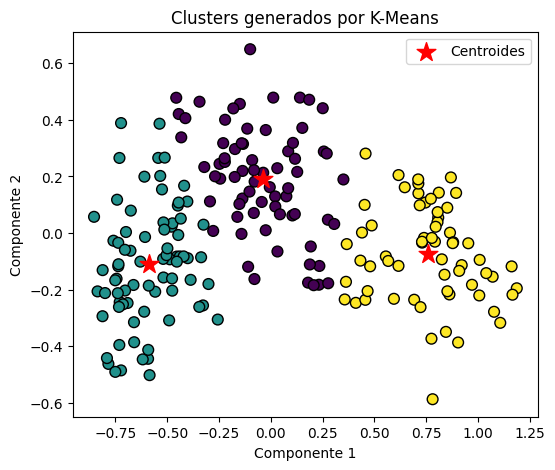

In [8]:
km_final = KMeans(n_clusters=3, n_init=25, random_state=NIA)                    # Creamos un KMeans con 3 clusters, 25 inicializaciones y semilla NIA para reproducibilidad
clusters_km = km_final.fit_predict(X_2d)                                        # Entrenamos el KMeans usando los datos en 2d (X_2d) y asignamos cada punto a un cluster

plt.figure(figsize=(6, 5))                                                      # Creamos una figura para visualizar el gráfico

# ═══════════════════════════ Dibujamos los puntos ═════════════════════════════

plt.scatter(x = X_2d[:, 0],                                                     # Graficamos los puntos, primera componente para el eje X
            y = X_2d[:, 1],                                                     # Graficamos los puntos, segunda componente para el eje Y
            c=clusters_km,                                                      # Coloreamos los puntos de cada cluster
            s=60,                                                               # Tamaño de cada punto
            edgecolor='black')                                                  # Ponemos el borde de cada punto a negro

# ═══════════════════ Dibujamos los centroides (estrellitas) ═══════════════════

plt.scatter(km_final.cluster_centers_[:, 0],                                    # Dibujamos los centroides, primera coord de cada centroide para el eje X
            km_final.cluster_centers_[:, 1],                                    # Dibujamos los centroides, segunda coord de cada centroide para el eje Y
            c='red',                                                            # Coloreamos los centroides en rojo
            s=200,                                                              # Ponemos un tamaño muy alto para destacar los centroides
            marker='*',                                                         # Ponemos que los centroides sean una estrellita
            label='Centroides')                                                 # Ponemos un label para la leyenda

plt.title("Clusters generados por K-Means")                                     # Asignamos un título al gráfico
plt.xlabel("Componente 1")                                                      # Asignamos un título al eje X
plt.ylabel("Componente 2")                                                      # Asignamos un título al eje Y
plt.legend()                                                                    # Mostramos la leyenda
plt.show()                                                                      # Mostramos el gráfico en pantalla

En el modelo final de K-Means podemos apreciar tres grupos de puntos, cada uno con un color distinto. Los centroides aparecen con estrellitas rojas, en el centro de cada conjunto.

Observamos que K-Means ha logrado encontrar tres clusters en los datos 2D, que se concentran alrededor de su centroide. La separación entre clusters es buena, por lo que nuestra decisión de elegir K=3 como número óptimo de clusters es acertada.

**Clustering jerárquico (dendogramas)**

El clustering jerárquico (dendogramas) organiza los datos en una estructura de árbol, donde en cada nodo se representa la fusión o separación de los clusters hasta conseguir llegar a un único cluster que incluye a todos los datos.

Visualizamos los resultados mediante un dendograma, que nos permite analizar de forma visual a través de cortes en la altura el número óptimo de clusters.

- Función para representar un dendograma

In [9]:
from scipy.cluster.hierarchy import dendrogram                                  # Importamos la función 'dendrogram' para graficar el dendrograma
from sklearn.cluster import AgglomerativeClustering                             # Importamos el modelo de clustering jerárquico


def plot_dendrogram(model, **kwargs):                                           # Definimos la función 'plot_dendrogram' que toma un modelo de clustering y argumentos adicionales para graficar
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])                                 # Obtenemos el número de muestras en cada cluster
    n_samples = len(model.labels_)                                              # Obtenemos el número total de muestras a partir de los labels del modelo
    for i, merge in enumerate(model.children_):                                 # Recorremos cada fusión de clusters
        current_count = 0                                                       # Inicializamos el contador de muestras en el cluster actual
        for child_idx in merge:                                                 # Recorremos cada índice de los nodos que se fusionan en esta iteración
            if child_idx < n_samples:                                           # Si el índice es menor que el número total de muestras, es un cluster
                current_count += 1  # leaf node                                 # Incrementamos el contador en 1 para cada nodo hoja
            else:                                                               # Si el índice es mayor o igual a n_samples, se trata de un nodo ya fusionado
                current_count += counts[child_idx - n_samples]                  # Sumamos al contador el número de muestras que ya se han fusionado en ese nodo
        counts[i] = current_count                                               # Guardamos el valor del contador en counts

    linkage_matrix = np.column_stack([model.children_,                          # Creamos la matriz de enlace combinando
                                      model.distances_,                         #  Ponemos los índices de las fusiones,
                                      counts]).astype(float)                    #  Ponemos las distancias de fusión y el número de muestras en cada fusión, convirtiéndola a tipo float

    # Plot
    dendrogram(linkage_matrix, **kwargs)                                        # Finalmente, graficamos el dendrograma usando la 'linkage_matrix' y cualquier argumento adicional

 - Comparamos los resultados con los linkages complete, ward y average

In [10]:
modelo_hclust_complete = AgglomerativeClustering(                               # Creamos el modelo de clustering jerárquico: Linkage complete
    metric = 'euclidean',                                                       # Usamos la distancia euclidiana para medir similitud entre puntos
    linkage  = 'complete',                                                      # Configuramos el linkage a 'complete', que considera la máxima distancia entre los puntos de los clusters
    distance_threshold = 0,                                                     # Establecemos el umbral de distancia a 0 para obtener el dendrograma completo
    n_clusters         = None                                                   # No fijamos el número de clusters, permitiendonos ver todo el árbol jerárquico
)
modelo_hclust_complete.fit(X=X_2d)                                              # Ajustamos el modelo a los datos transformados a 2 dimensiones

modelo_hclust_average = AgglomerativeClustering(                                # Creamos el modelo de clustering jerárquico: Linkage average
    metric = 'euclidean',                                                       # Usamos la distancia euclidiana para medir similitud entre puntos
    linkage  = 'average',                                                       # Configuramos el linkage a 'average', que usa la distancia promedio entre los puntos de los clusters
    distance_threshold = 0,                                                     # Umbral de distancia en 0 para ver el dendrograma completo
    n_clusters         = None                                                   # No fijamos el número de clusters, permitiendonos ver todo el árbol jerárquico
)
modelo_hclust_average.fit(X=X_2d)                                               # Ajustamos el modelo a los datos transformados a 2 dimensiones

modelo_hclust_ward = AgglomerativeClustering(                                   # Creamos el modelo de clustering jerárquico: Linkage ward
    linkage  = 'ward',                                                          # Usamos la distancia euclidiana para medir similitud entre puntos
    distance_threshold = 0,                                                     # Umbral de distancia en 0 para ver el dendrograma completo
    n_clusters         = None                                                   # No fijamos el número de clusters, permitiendonos ver todo el árbol jerárquico
)
modelo_hclust_ward.fit(X=X_2d)                                                  # Ajustamos el modelo a los datos transformados a 2 dimensiones

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

- Representamos los dendogramas

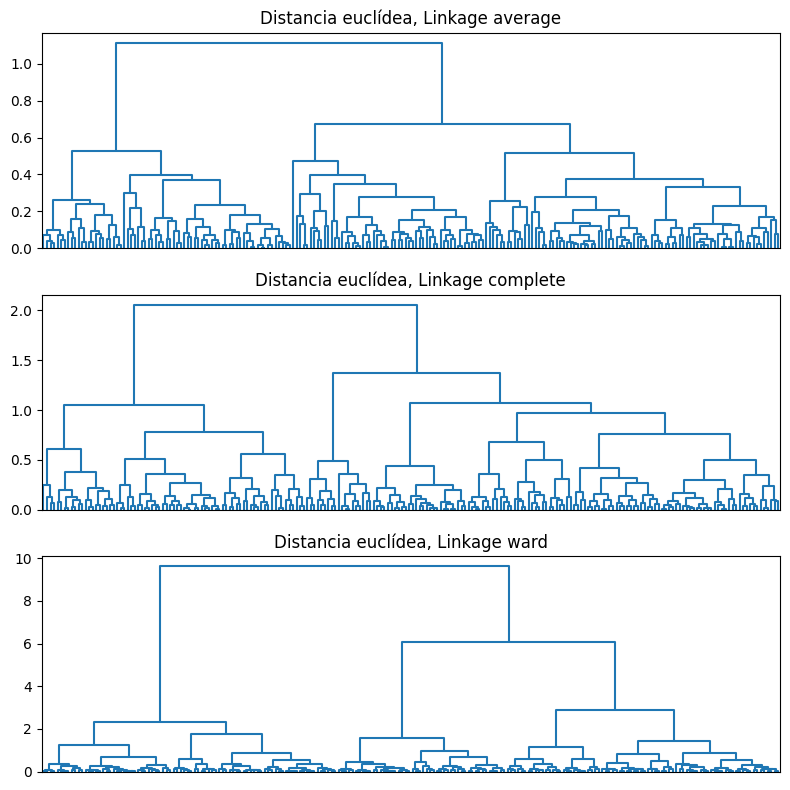

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))                                   # Creamos una figura con 3 subplots en una columna

plot_dendrogram(modelo_hclust_average, labels=dataframe_semillas.index, color_threshold=0, ax=axs[0])     # Dibujamos el dendrograma para linkage "average" en el primer subplot
axs[0].set_title("Distancia euclídea, Linkage average")                                                   # Asignamos el título al primer subplot
axs[0].set_xticklabels([])                                                                                # Eliminamos las etiquetas del eje X del primer subplot

plot_dendrogram(modelo_hclust_complete, labels=dataframe_semillas.index, color_threshold=0, ax=axs[1])    # Dibujamos el dendrograma para linkage "complete" en el segundo subplot
axs[1].set_title("Distancia euclídea, Linkage complete")                                                  # Asignamos el título al segundo subplot
axs[1].set_xticklabels([])                                                                                # Eliminamos las etiquetas del eje X del segundo subplot

plot_dendrogram(modelo_hclust_ward, labels=dataframe_semillas.index, color_threshold=0, ax=axs[2])        # Dibujamos el dendrograma para linkage "ward" en el tercer subplot
axs[2].set_title("Distancia euclídea, Linkage ward")                                                      # Asignamos el título al tercer subplot
axs[2].set_xticklabels([])                                                                                # Eliminamos las etiquetas del eje X del tercer subplot

plt.tight_layout()                                                              # Ajustamos el espacio entre subplots

En cuanto a Linkage average, se fusionan primero los puntos y clusters mas cercanos. Apreciamos como a alturas bajas existen muchas fusiones, lo que indica que los clusters pequeños se van uniendo progresivamente hasta llegar a un único cluster que incluye todos los datos.

Sobre Linkage complete, los clusters se fusionan mediante la máxima distancia entre puntos de grupos diferentes. Observamos que el dendograma es más estricto a la hora de unir clusters, es decir, si los puntos son muy diferentes se fusionarán a una altura mayor.

Por último Linkage ward, los clusters se fusionan minimizando la varianza interna. Notamos una diferencia de altura muy grande donde los grupos pequeños se combinan en un único cluster, debido a que Ward junta los puntos minimizando la dispersión dentro de cada cluster.

- Número de clusters mediante la altura de corte

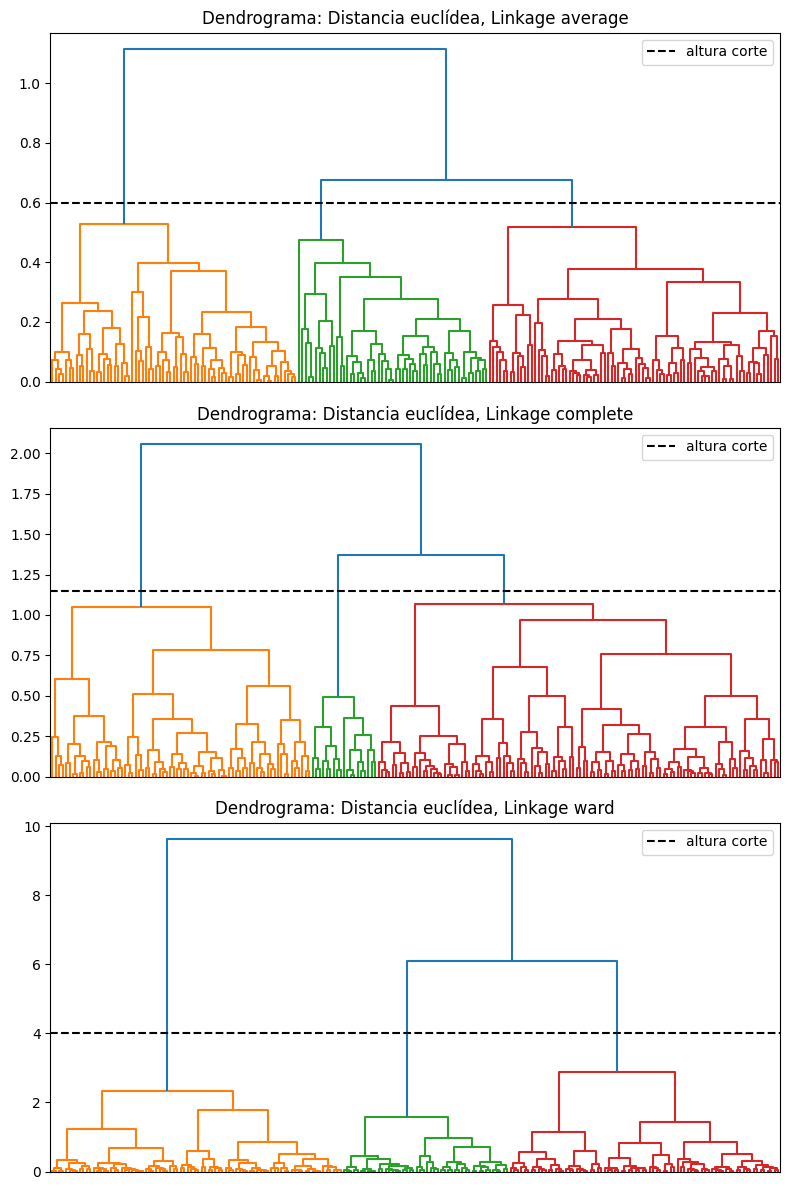

In [12]:
figura, ejes = plt.subplots(3, 1, figsize=(8, 12))                              # Creamos una figura con 3 subplots en una columna y tamaño 8x12

plot_dendrogram(modelo_hclust_average, labels=dataframe_semillas.index, color_threshold=0.6, ax=ejes[0])           # Dibujamos el dendrograma para linkage "average" en el primer subplot, usando los índices del dataframe como etiquetas y estableciendo el umbral de color a 0.6
ejes[0].set_title("Dendrograma: Distancia euclídea, Linkage average")                                              # Asignamos el título al primer subplot
ejes[0].set_xticklabels([])                                                                                        # Eliminamos las etiquetas del eje X del primer subplot
ejes[0].axhline(y=0.6, color='black', linestyle='--', label='altura corte')                                        # Dibujamos una línea horizontal en y=0.6 para marcar la altura de corte
ejes[0].legend()                                                                                                   # Mostramos la leyenda en el primer subplot

plot_dendrogram(modelo_hclust_complete, labels=dataframe_semillas.index, color_threshold=1.15, ax=ejes[1])         # Dibujamos el dendrograma para linkage "complete" en el segundo subplot, con umbral de color a 1.15
ejes[1].set_title("Dendrograma: Distancia euclídea, Linkage complete")                                             # Asignamos el título al segundo subplot
ejes[1].set_xticklabels([])                                                                                        # Eliminamos las etiquetas del eje X del segundo subplot
ejes[1].axhline(y=1.15, color='black', linestyle='--', label='altura corte')                                       # Dibujamos una línea horizontal en y=1.15 para marcar la altura de corte
ejes[1].legend()                                                                                                   # Mostramos la leyenda en el segundo subplot

plot_dendrogram(modelo_hclust_ward, labels=dataframe_semillas.index, color_threshold=4, ax=ejes[2])               # Dibujamos el dendrograma para linkage "ward" en el tercer subplot, con umbral de color a 4
ejes[2].set_title("Dendrograma: Distancia euclídea, Linkage ward")                                                # Asignamos el título al tercer subplot
ejes[2].set_xticklabels([])                                                                                       # Eliminamos las etiquetas del eje X del tercer subplot
ejes[2].axhline(y=4, color='black', linestyle='--', label='altura corte')                                         # Dibujamos una línea horizontal en y=4 para marcar la altura de corte
ejes[2].legend()                                                                                                  # Mostramos la leyenda en el tercer subplot

plt.tight_layout()                                                              # Ajustamos el espacio entre subplots
plt.show()                                                                      # Mostramos la figura completa con los tres dendrogramas

Observamos la línea discontinua que representa la altura de corte en cada uno de los dendogramas.

En cuanto a Linkage average, vemos que a una altura de 0.6 se forman tres grupos principales de colores naranja, verde y rojo. Esta altura refleja la distancia promedio ente los puntos de los clusters.

Sobre Linkage complete, obtenemos tres clusters a una altura de 1.15. Este método es más cuidadoso, vemos como el cluster naranja se separa antes de llegar a una altura de 1, mientras que los otros dos clusters se forman más tarde.

Por último con Linkage ward, trazamos la altura de corte en 4, donde se consiguen identificar tres clusters. Observamos un salto grande en el que se unen casi todos los puntos, visualmente observamos grupos más compactos y con menos dispersión.

- Número de clusters mediante el índice silhouette

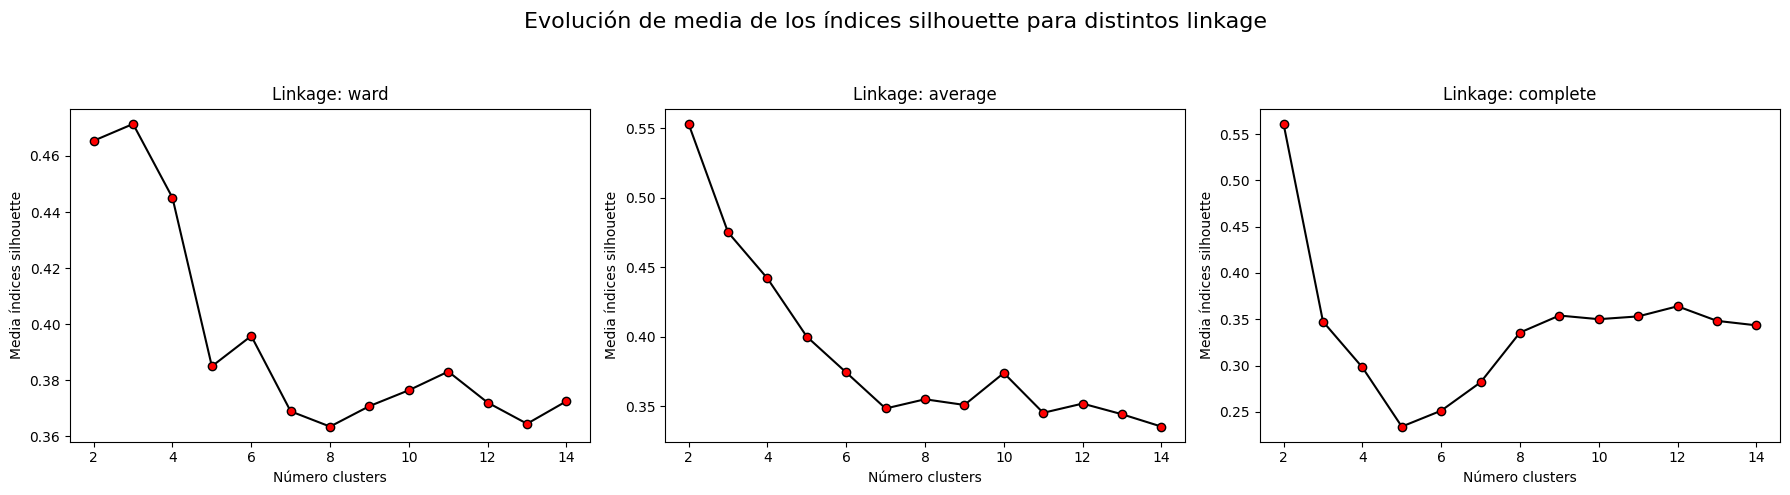

In [13]:
metodos_linkage = {                                                             # Definimos un diccionario con los métodos de linkage a evaluar
    'ward': 'ward',                                                             # Incluimos 'ward'
    'average': 'average',                                                       # Incluimos 'average'
    'complete': 'complete'                                                      # Incluimos 'complete'
}

range_n_clusters = range(2, 15)                                                 # Definimos el rango de números de clusters a probar (de 2 a 15)

figura, ejes = plt.subplots(1, 3, figsize=(18, 5))                                                       # Creamos una figura con 3 subplots en una fila
figura.suptitle("Evolución de media de los índices silhouette para distintos linkage", fontsize=16)      # Ponemos el título principal de la figura

contador = 0                                                                    # Inicializamos un contador para recorrer los subplots

for nombre_linkage in metodos_linkage:                                          # Iteramos sobre cada método de linkage definido en el diccionario
    metodo_linkage = metodos_linkage[nombre_linkage]                            # Obtenemos el valor del método de linkage actual
    valores_medios_silhouette = []                                              # Inicializamos la lista para almacenar los índices silhouette medios

    for n_clusters in range_n_clusters:                                         # Probamos cada número de clusters dentro del rango definido
        modelo = AgglomerativeClustering(                                       # Creamos un modelo de clustering aglomerativo
            metric = 'euclidean',                                               # Usamos la métrica de distancia euclidiana
            linkage = metodo_linkage,                                           # Usamos el método de linkage actual (ward, average o complete)
            n_clusters = n_clusters                                             # Establecemos el número de clusters
        )

        cluster_labels = modelo.fit_predict(X_2d)                               # Entrenamos el modelo y asignamos cada punto a un cluster
        silhouette_avg = silhouette_score(X_2d, cluster_labels)                 # Calculamos el índice silhouette para evaluar la calidad de los clusters
        valores_medios_silhouette.append(silhouette_avg)                        # Guardamos el valor medio de silhouette en la lista

    eje_actual = ejes[contador]                                                 # Seleccionamos el subplot correspondiente según el contador

    eje_actual.plot(                                                            # Graficamos la evolución del índice silhouette
        range_n_clusters,                                                       # Eje X: valores de K
        valores_medios_silhouette,                                              # Eje Y: silhouette medio para cada K
        marker='o',                                                             # Marcador circular
        color='black',                                                          # Línea en negro
        markerfacecolor='red',                                                  # Relleno de marcadores en rojo
        markeredgecolor='black'                                                 # Borde de marcadores en negro
    )
    eje_actual.set_title("Linkage: " + nombre_linkage)                          # Asignamos el título del subplot indicando el método de linkage
    eje_actual.set_xlabel('Número clusters')                                    # Etiqueta del eje X
    eje_actual.set_ylabel('Media índices silhouette')                           # Etiqueta del eje Y

    contador += 1                                                               # Incrementamos el contador para el siguiente subplot

plt.tight_layout(rect=[0, 0, 1, 0.93])                                          # Ajustamos el espacio entre subplots
plt.show()                                                                      # Mostramos la figura con todos los subplots

Observamos y comparamos cómo varía el índice silhouette al cambiar el número de clusters para cada método.

En cuanto a Linkage average, el valor de silhouette más alto se obtiene con 2 clusters, en torno a 0.56. Con 3 clusters, obtenemos un valor muy bueno también alrededor de 0.47. A partir de 4 clusters, el índice desciende de manera más significativa lo que no indica mejora.

Sobre Linkage complete, el mayor índice se obtiene cuando se utilizan 2 clusters, sobre 0.57, siendo este el mayor pico de todos. Del mismo modo que en el anterior, a medida que incrementan los clusters, el valor desciende mucho.

Por último con Linkage ward, obtenemos el mejor índice con 3 clusters en torno a 0.50. Con 4 clusters obtenemos un valor muy bueno también, sobre 0.45. Y como en los anteriores, a medida que se aumentan los clusters, el índice disminuye.

Concluimos identificando que el mejor índice de silhouette se obtiene con Linkage complete, utilizando 2 clusters. Sin embargo, en nuestro caso 2 clusters es demasiado general, y es por ello que revisamos el siguiente mejor pico con 3 clusters, siendo Linkage ward con el que continuaremos.

- Modelo final con el número óptimo de clusters

In [14]:
modelo_hclust_ward = AgglomerativeClustering(                                   # Creamos el modelo de clustering jerárquico
    linkage  = 'ward',                                                          # Usamos el método 'ward' que minimiza la varianza intra-cluster
    n_clusters = 3                                                              # Establecemos el número óptimo de clusters a 3
)
modelo_hclust_ward.fit(X=X_2d)                                                  # Entrenamos el modelo con los datos en 2d (X_2d)

AgglomerativeClustering(n_clusters=3)

**DBSCAN**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) crea clusters mediante puntos que están conectados que están, permitiendo identificar clusters y detectar outliers. DBSCAN utilia los parámetros:

- **eps**: es el radio dentro del cual se consideran conectados.

- **min_samples**: el número mínimo de vecinos para formar un cluster.

Un punto en los datos se puede clasificar como:

- **núcleo**: si tiene al menos min_samples vecinos dentro del radio eps.

- **frontera/borde**: si en un radio eps no alcanza a tener min_samples.

- **ruido**: si no es nucleo ni frontera/borde.

- Lectura de datos

In [15]:
from sklearn.cluster import DBSCAN                                              # Importamos el modelo DBSCAN
datos = pd.read_csv('DBSCAN.csv')                                               # Leemos el archivo y lo almacenamos en un dataFrame
datos.head()                                                                    # Mostramos las primeras filas del dataframe

,x,y,shape
0,-0.803739,-0.853053,1
1,0.852851,0.367618,1
2,0.927180,-0.274902,1
3,-0.752626,-0.511565,1
4,0.706846,0.810679,1


- Modelo de DBSCAN

Aplicamos DBSCAN sobre los datos reducidos X_2d con eps=0.2 y min_samples=5, usando distancia euclidiana.

In [16]:
modelo_dbscan = DBSCAN(                                                         # Creamos el modelo DBSCAN
    eps          = 0.2,                                                         # Es el radio dentro del cual se consideran conectados
    min_samples  = 5,                                                           # Es el numero minimo de vecinos
    metric       = 'euclidean',                                                 # Usamos la distancia euclidiana para la medir similitud entre puntos
)
modelo_dbscan.fit(X=X_2d)                                                       # Entrenamos el modelo con los datos en dos dimensiones

DBSCAN(eps=0.2)

- Clasificación mediante DBSCAN

Una vez entrenado el modelo DBSCAN sobre X_2d, visualizamos la agrupación de los datos. Coloreamos los puntos según su etiqueta de cluster, y coloreamos los outliers de rojo

Número de clusters encontrados: 1
Número de outliers encontrados: 1


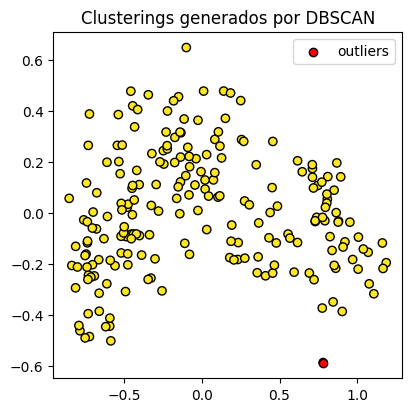

In [17]:
labels = modelo_dbscan.labels_                                                  # Obtenemos etiquetas asignadas por DBSCAN para cada punto
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))                                # Creamos una figura para ver el gráfico

ax.scatter(                                                                     # Graficamos los puntos
    x = X_2d[:, 0],                                                             # Tomamos la primera columna de X_2d como coordenada X
    y = X_2d[:, 1],                                                             # Tomamos la segunda columna de X_2d como coordenada Y
    c = labels,                                                                 # Coloreamos los puntos
    marker    = 'o',                                                            # Ponemos un marcador circular
    edgecolor = 'black'                                                         # El borde de los puntos en negro
)

ax.scatter(                                                                     # Graficamos los outliers
    x = X_2d[labels == -1, 0],                                                  # Filtramos la coordenada X de los puntos con etiqueta -1
    y = X_2d[labels == -1, 1],                                                  # Filtramos la coordenada Y de los puntos con etiqueta -1
    c = 'red',                                                                  # Usamos rojo para resaltar los outliers
    marker    = 'o',                                                            # Mantenemos círculos como marcador
    edgecolor = 'black',                                                        # Conservamos el borde negro en los marcadores
    label = 'outliers'                                                          # Añadimos una etiqueta a la leyenda
)

ax.legend()                                                                     # Mostramos la leyenda para identificar los outliers
ax.set_title('Clusterings generados por DBSCAN');                               # Ponemos un título al grafico

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)                      # Calculamos cuántos clusters distintos hay, sin el ruido
n_noise    = list(labels).count(-1)                                             # Vemos los puntos ruidosos o outliers

print("Número de clusters encontrados:", n_clusters)                            # Mostramos por pantalla el número de clusters detectados
print("Número de outliers encontrados:", n_noise)                               # Mostramos por pantalla los outliers

Como podemos observar en el gráfico, una eps=0.2, DBSCAN detecta solo 1 cluster y 1 outlier, lo que nos indica que el valor de eps puede que sea más alto de lo que debería ser.

- Determinamos una eps adecuada

Como consecuencia del problema anterior, buscamos una eps adecuada en DBSCAN utilizando el gráfico k-distance, que nos dam la distancia de cada punto a su  vecino más cercano. Lo que haremos será detectar el “codo” de la curva, siendo ese valor una buena elección para el parámetro eps.

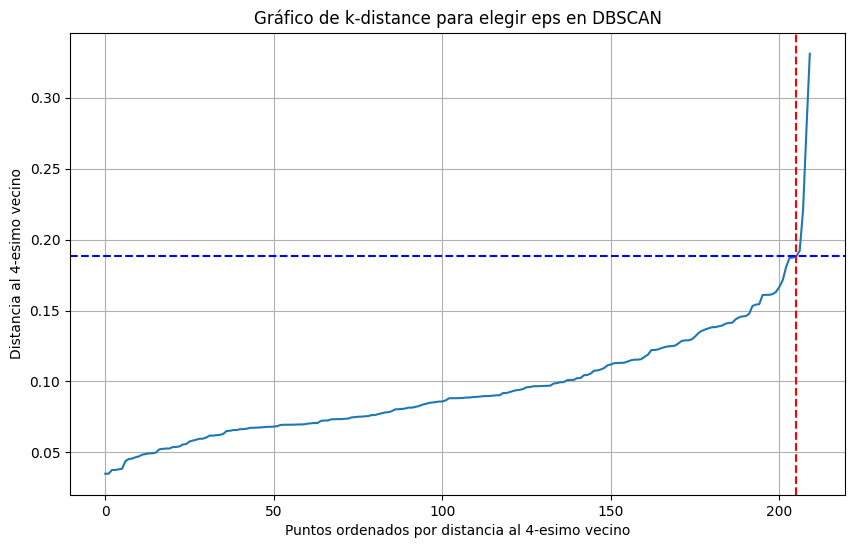

x_point = 205 y_value = 0.1883725581332985


In [18]:
from sklearn.neighbors import NearestNeighbors                                  # Importamos el modelo NearestNeighbors
import matplotlib.pyplot as plt                                                 # Importamos la librería pyplot para graficar

min_samples = 5                                                                 # Ponemos a 5 los vecinos mínimos

nn = NearestNeighbors(n_neighbors=min_samples)                                  # Inicializamos el modelo con el número de vecinos
nn.fit(X_2d)                                                                    # Entrenamos el modelo con nuestros datos en dos dimensiones
distances, indices = nn.kneighbors(X_2d)                                        # Calculamos las distancias y los índices de los k vecinos

sorted_distances = np.sort(distances[:, min_samples-1], axis=0)                 # Ordenamos las distancias de menor a mayor

x_point = 205                                                                   # Elegimos el punto para poner la línea vertical, es 205 porque ahi esta el codo
y_value = sorted_distances[x_point]                                             # Obtenemos la distancia correspondiente al punto

plt.figure(figsize=(10, 6))                                                            # Creamos una figura de 10×6
plt.plot(sorted_distances)                                                             # Hacemos el grafico
plt.xlabel('Puntos ordenados por distancia al {}-esimo vecino'.format(min_samples-1))  # Etiquetamos el eje X
plt.ylabel('Distancia al {}-esimo vecino'.format(min_samples-1))                       # Etiquetamos el eje Y
plt.title('Gráfico de k-distance para elegir eps en DBSCAN')                           # Ponemos un título al gráfico

plt.axvline(x=x_point, color='r', linestyle='--')                                     # Ponemos una línea vertical en el punto elegido
plt.axhline(y=y_value, color='b', linestyle='--')                                     # Y ponemos una línea horizontal en la distancia que sea

plt.grid(True)                                                                  # Ponemos cuadricula
plt.show()                                                                      # Mostramos el gráfico

print('x_point =', x_point, 'y_value =', y_value)                               # Mostramos los valores de x_point y y_value

Como podemos observar en el gráfico, el "codo" en la curva ocurre cerca del punto 205, con una distancia de 0.1833. Esto nos indica que una eps ≈ 0.1833 es un valor adecuado para DBSCAN, separando correctamente los puntos aislados de los outliers.

- Aplicación final de DBSCAN

Volvemos a aplicar DBSCAN con eps = 0.1883 y min_samples = 5 sobre los datos reducidos X_2d usando distancia euclidiana para obetener el modelo DBSCAN final con el parámetro eps ajustado.

Número de clusters encontrados: 1
Número de outliers encontrados: 2


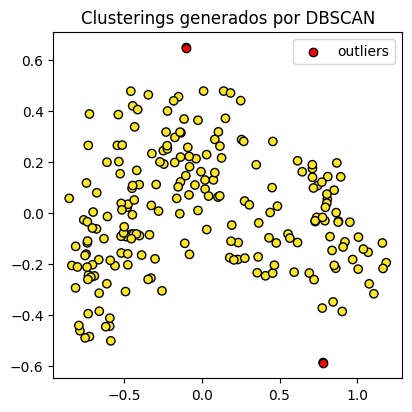

In [19]:
# ═════════════════════════════ Modelo Final ═══════════════════════════════════
modelo_dbscan = DBSCAN(                                                         # Creamos el modelo DBSCAN
    eps          = y_value,                                                     # Ponemos como eps el valor obtenido en el apartado anterior (óptimo)
    min_samples  = 5,                                                           # El número final de vecinos seguirá siendo 5
    metric       = 'euclidean',                                                 # La distancia seguirá siendo euclediana
)

modelo_dbscan.fit(X=X_2d)                                                       # Entrenamos el modelo con los datos en dos dimensiones

# ═════════════════════════════ Clasificación ══════════════════════════════════
labels = modelo_dbscan.labels_                                                  # Obtenemos etiquetas asignadas por DBSCAN para cada punto
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))                                # Creamos una figura para ver el gráfico

ax.scatter(                                                                     # Graficamos los puntos
    x = X_2d[:, 0],                                                             # Tomamos la primera columna de X_2d como coordenada X
    y = X_2d[:, 1],                                                             # Tomamos la segunda columna de X_2d como coordenada Y
    c = labels,                                                                 # Coloreamos los puntos
    marker    = 'o',                                                            # Ponemos un marcador circular
    edgecolor = 'black'                                                         # El borde de los puntos en negro
)

ax.scatter(                                                                     # Graficamos los outliers
    x = X_2d[labels == -1, 0],                                                  # Filtramos la coordenada X de los puntos con etiqueta -1
    y = X_2d[labels == -1, 1],                                                  # Filtramos la coordenada Y de los puntos con etiqueta -1
    c = 'red',                                                                  # Usamos rojo para resaltar los outliers
    marker    = 'o',                                                            # Mantenemos círculos como marcador
    edgecolor = 'black',                                                        # El borde de los puntos en negro
    label = 'outliers'                                                          # Añadimos una etiqueta a la leyenda
)

ax.legend()                                                                     # Mostramos la leyenda para identificar los outliers
ax.set_title('Clusterings generados por DBSCAN')                                # Ponemos un título al grafico

# ══════════════════════════ Clusters y outliers ═══════════════════════════════
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)                      # Calculamos cuántos clusters distintos hay, sin el ruido
n_noise    = list(labels).count(-1)                                             # Vemos los puntos ruidosos o outliers

print("Número de clusters encontrados:", n_clusters)                            # Mostramos por pantalla el número de clusters detectados
print("Número de outliers encontrados:", n_noise)                               # Mostramos por pantalla los outliers

Como podemos observar en el gráfico, DBSCAN con eps = 0.1833 detecta 1 cluster y 2 outliers. Este ajuste en el parámetro eps ha mejorado la detección de ruido en los datos.

---

### **4. ANÁLISIS Y EVALUACIÓN DE RESULTADOS**

En este apartado nos centraremos en la evaluación de los tres métodos de Clustering que hemos utilizado: K-Means, Jerárquico y DBSCAN.



**Comprobación visual de los métodos de Clustering**

Las gráficas que se muestran en el apartado anterior nos proporcionan la siguiente información:
-  K-Means: nos muestra 3 clusters bien diferenciados, con los centroides posicionados en el centro de cada cluster y una buena separación entre clusters.
- Dendogramas: siendo Linkage average el que muestra una estructura más gradual de combinación de clusters, Linkage complete el que muestra combinaciones a mayores distancias y Linkage ward el que presenta el salto más claro para identificar los tres clusters.
- DBSCAN: al estar los puntos relativamente juntos en el plano, el resultado obtenido de DBSCAN es un 1 cluster y 2 puntos ruidosos.

La comparación visual de los métodos nos lleva a las siguientes conclusiones:
- K-Means y Dendogramas usando Linkage ward son capaces de capturar la estructura de 3 clusters de forma evidente en los datos.
- El corte en el dendograma usando Linkage ward a una altura de ~4 nos confirma que 3 clusters son posibles.
- DBSCAN, en cambio, no consigue separar correctamente los clusters y no nos resulta útil en este conjunto de datos.

Entonces, podemos decir que K-Means (k=3) o Dendogramas con Linkage ward (3 clusters) son buenos métodos para utilizar en este conjunto de semillas.

**Relación entre clusters obtenidos y clases de semillas originales**

In [20]:
print("K‑Means vs. clase original:")                                            # Vamos a comparar K-Means con la clase real
display(pd.crosstab(clusters_km, dataframe_semillas['clase']))                  # Creamos y mostramos la tabla entre los clusters de K-Means y las clases reales

for linkage in ['complete', 'average', 'ward']:                                 # Iteramos en los métodos de linkage
    modelo = AgglomerativeClustering(n_clusters=3, linkage=linkage)             # Ponemos 3 clusters y el método de linkage actual
    clusters = modelo.fit_predict(X_2d)                                         # Entrenamos el modelo y obtenemos las etiquetas de los clusters
    print("Jerárquico," + linkage + "vs. clase original:")                      # Imprimimos este caso actual
    display(pd.crosstab(clusters, dataframe_semillas['clase']))                 # Creamos y mostramos la tabla entre los clusters y las clases reales
    print("---------------------------------------------------")

print("DBSCAN vs. clase original:")                                             # Vamos a comparar DBSCAN con la clase real
display(pd.crosstab(modelo_dbscan.labels_, dataframe_semillas['clase']))        # Creamos y mostramos la tabla de entre clusters DBSCAN y clases reales

K‑Means vs. clase original:


clase,1,2,3
row_0,,,
0,58,9,3
1,10,0,67
2,2,61,0


Jerárquico,completevs. clase original:


clase,1,2,3
row_0,,,
0,46,0,70
1,7,68,0
2,17,2,0


---------------------------------------------------
Jerárquico,averagevs. clase original:


clase,1,2,3
row_0,,,
0,3,68,0
1,14,0,70
2,53,2,0


---------------------------------------------------
Jerárquico,wardvs. clase original:


clase,1,2,3
row_0,,,
0,56,22,0
1,14,0,70
2,0,48,0


---------------------------------------------------
DBSCAN vs. clase original:


clase,1,2,3
row_0,,,
-1,1,1,0
0,69,69,70


Los resultados obtenidos con el método K-Means nos indican que:
- K-Means separa muy bien las tres clases que teníamos en los datos originales.
- Cada cluster tiene una clase muy predominante sobre las demás.

Los resultados obtenidos con los métodos jerárquicos nos indican que:
- Jerárquico complete: confunde mucho la clase 1 con la 3 en el cluster 0, no serpara bien las clases.
- Jerárquico average: clasifica bien las clases 2 y 3, aunque la clase 1 tiene un poco de dispersión con 14 puntos mal puestos en el cluster 1.
- Jerárquico ward: la clase 3 está perfectamente agrupada, pero la clase 2 está dividida entre dos clusters.

Los resultados obtenidos con DBSCAN nos indican que:
- No distingue entre las 3 clases originales, y agrupa casi todos los puntos en un único cluster.
- Solo detecta 2 outliers, uno de clase 1 y otro de clase 2.

**Interpretación de clusters con boxplots**

Como conclusión del análisis y evaluación de resultados, representamos mediante boxplots cada atributo (área, perímetro, compacidad, longitud, anchura, asimetría y surco).

En cada boxplot mostramos como cambia un atributo en cada cluster.

- En la línea central de cada caja ponemos la mediana.

- La altura de la caja nos indica la dispersión que tiene (IQR).

- En los boxplots hemos puesto los outliers como puntos individuales.

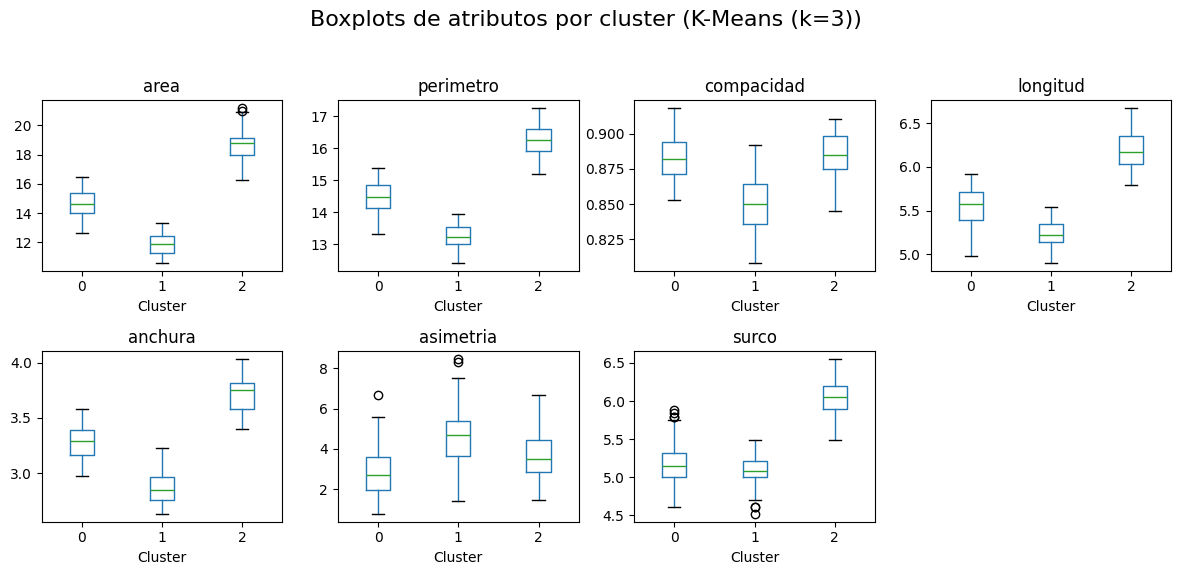

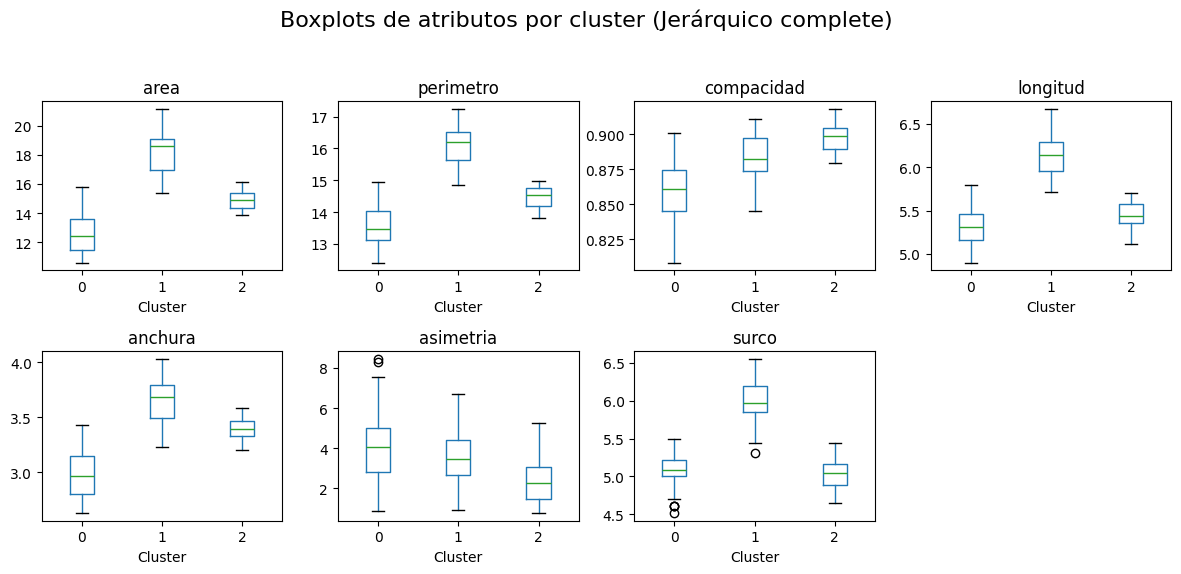

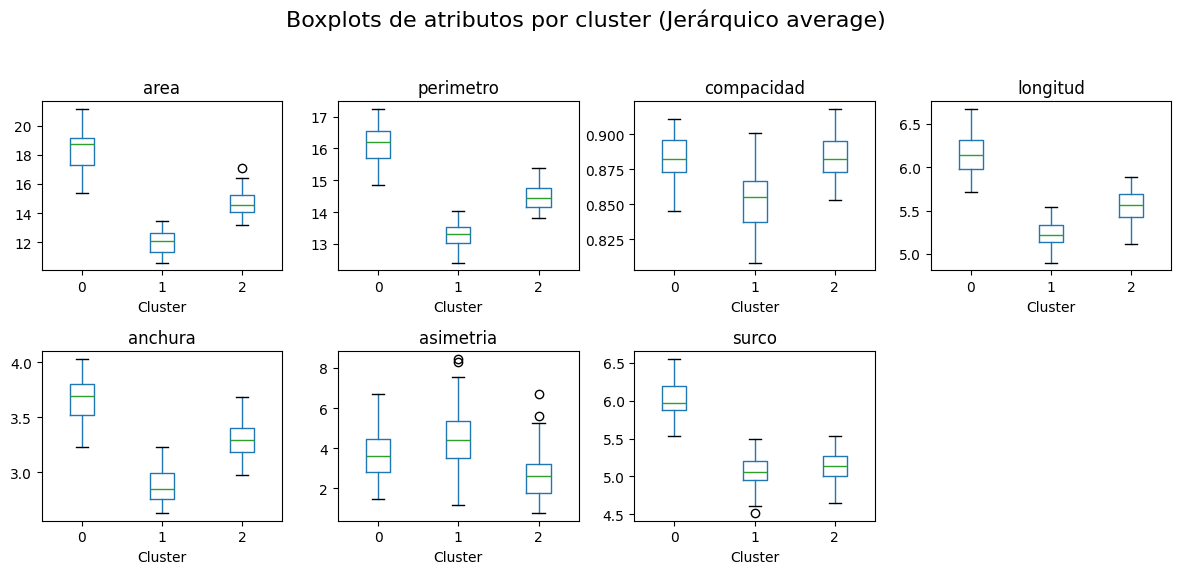

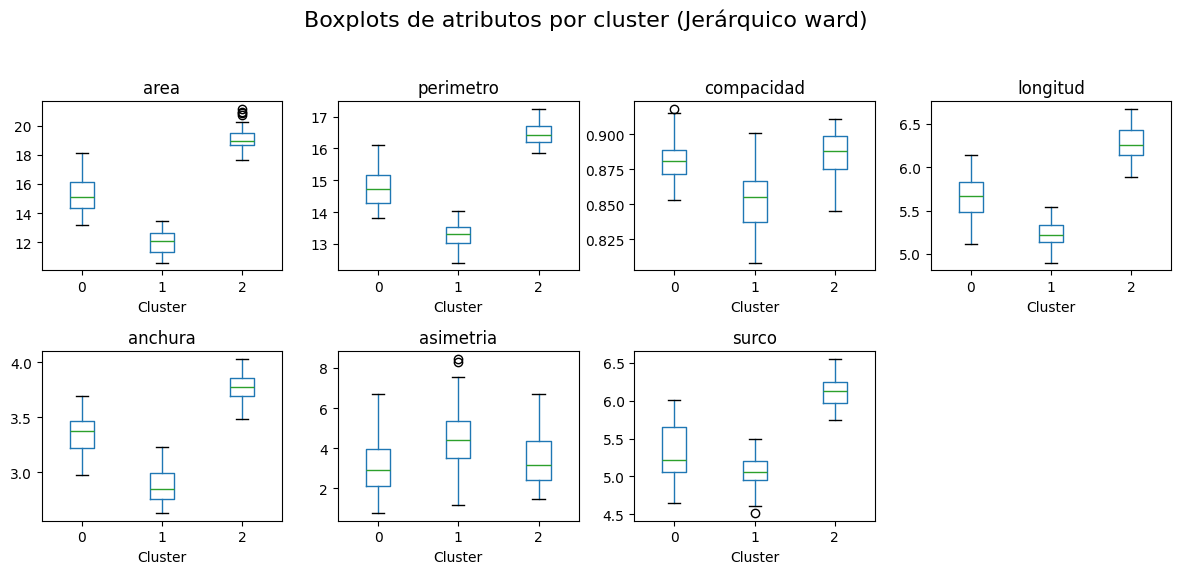

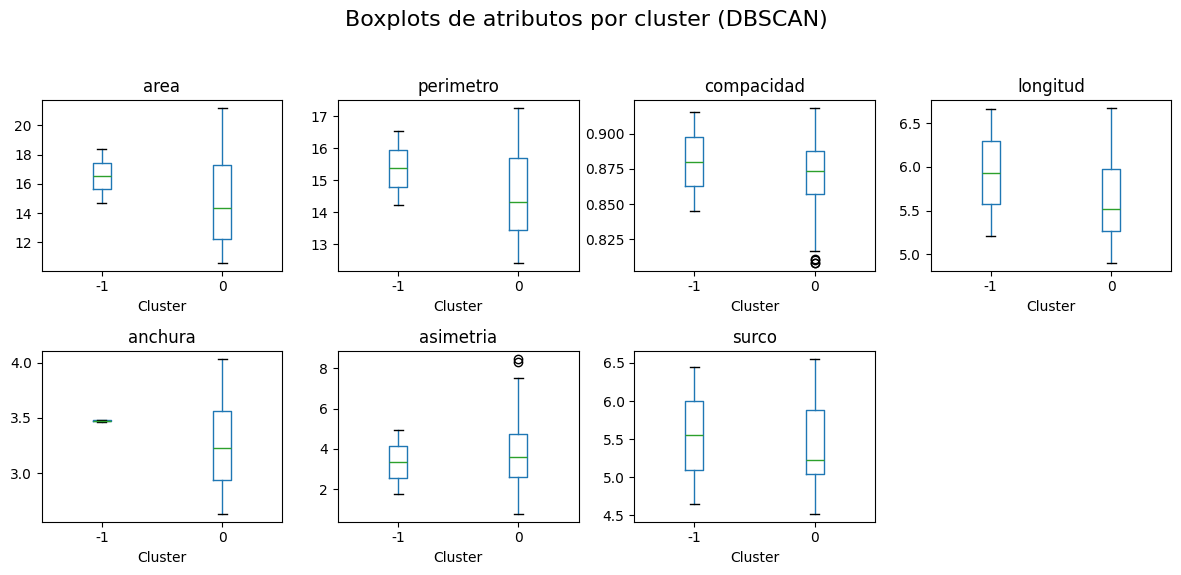

In [21]:
import numpy as np                                                              # Importamos numpy para operaciones numéricas
import matplotlib.pyplot as plt                                                 # Importamos la librería pyplot para graficar
from sklearn.cluster import AgglomerativeClustering                             # Importamos el modelo AgglomerativeClustering

clusters_dict = {                                                                                            # Creamos un diccionario con los métodos de clustering y sus etiquetas
    "K-Means (k=3)":        clusters_km,                                                                     # Etiquetas generadas por K-Means con k=3
    "Jerárquico complete":  AgglomerativeClustering(n_clusters=3, linkage='complete').fit_predict(X_2d),     # Clustering jerárquico con 'complete'
    "Jerárquico average":   AgglomerativeClustering(n_clusters=3, linkage='average').fit_predict(X_2d),      # Clustering jerárquico con 'average'
    "Jerárquico ward":      AgglomerativeClustering(n_clusters=3, linkage='ward').fit_predict(X_2d),         # Clustering jerárquico con 'ward'
    "DBSCAN":               modelo_dbscan.fit_predict(X_2d)                                                  # Clustering DBSCAN
}

features = [c for c in dataframe_semillas.columns if c != "clase"]                # Listamos atributos excluyendo la columna de clase
n_features = len(features)                                                        # Contamos cuántos atributos hay
ncols = 4                                                                         # Definimos 4 columnas por fila
nrows = int(np.ceil(n_features / ncols))                                          # Calculamos el número de filas necesarias

for método, labels in clusters_dict.items():                                      # Iteramos por cada método de clustering
    dataframe_tmp = dataframe_semillas.copy()                                     # Hacemos una copia del dataframe original
    dataframe_tmp["cluster"] = labels                                             # Añadimos la columna de etiquetas de cluster

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), sharey=False) # Creamos figura y ejes
    axes = axes.flatten()                                                         # Aplanamos la matriz de ejes para iterar

    for i, feature in enumerate(features):                                        # Iteramos por cada atributo
        ax = axes[i]                                                              # Seleccionamos el eje correspondiente
        dataframe_tmp.boxplot(                                                    # Dibujamos boxplot del atributo
            column=feature,                                                       # Definimos la columna a graficar
            by="cluster",                                                         # Agrupamos por cluster
            ax=ax,                                                                # Indicamos el eje donde dibujar
            grid=False                                                            # Desactivamos cuadrícula en el boxplot
        )
        ax.set_title(feature)                                                   # Ponemos el nombre del atributo como título
        ax.set_xlabel("Cluster")                                                # Etiqueta del eje X
        ax.set_ylabel("")                                                       # Etiqueta del eje Y vacía

    for j in range(n_features, len(axes)):                                            # Para los ejes sin datos
        axes[j].axis("off")                                                           # Y desactivamos esos ejes

    plt.suptitle("Boxplots de atributos por cluster (" + método + ")", fontsize=16)   # Título general de la figura
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])                                         # Ajustamos el layout para evitar superposiciones
    plt.show()                                                                        # Mostramos la figura con los boxplots

**K-Means**

- *Cluster 0*: está en una posición intermedia en la que los valores de los atributos no son muy altos ni muy bajos. Es el cluster más equilibrado.


- *Cluster 1*: contiene las semillas más pequeñas y con menor compacidad, siendo el grupo más compacto en términos de forma y tamaño.

- *Cluster 2*: consigue agrupar las semillas con valores más altos en la mayoría de atributos, como área, perímetro, longitud, anchura y surco.

**Jerárquico complete**

- *Cluster 0*: agrupa las semillas con valores más bajos en la mayoría de los atributos, como área, perímetro, longitud, anchura y surco. Es decir, reúne las semillas más pequeñas y menos compactas. Además, es el cluster con mayor variabilidad en asimetría.

- *Cluster 1*: contiene las semillas con valores más altos en casi todos los atributos: área, perímetro, longitud, anchura y surco. También tiene alta compacidad. Este grupo representa a las semillas más grandes y homogéneas en tamaño, siendo el grupo con características más marcadas.

- *Cluster 2*: se sitúa en una posición intermedia entre los otros dos clusters. Su compacidad es alta, similar al cluster 1, pero su tamaño es más reducido. Este cluster podría representar una variedad más uniforme y moderada.

**Jerárquico average**

- *Cluster 0*: agrupa las semillas con los valores más altos en prácticamente todos los atributos, destacando especialmente en área, perímetro, longitud, anchura y surco.

- *Cluster 1*: contiene las semillas más pequeñas, con valores bajos en área, perímetro, longitud, anchura y surco. Además, vemos como en compacidad y asimetría se presentan valores más altos y algún outlier.

- *Cluster 2*:  está en una posición intermedia en la mayoría de atributos, sin valores especialmente altos ni bajos. Representa un grupo de semillas de tamaño medio y con características equilibradas.

**Jerárquico ward**

- *Cluster 0*: está en una posición intermedia en la mayoría de atributos, sin valores especialmente altos ni bajos. Representa un grupo de semillas de tamaño medio y con características equilibradas.

- *Cluster 1*: contiene las semillas más pequeñas, con valores bajos en área, perímetro, longitud, anchura y surco. También presenta menor compacidad, siendo el grupo más compacto en forma y tamaño.

- *Cluster 2*: agrupa las semillas con los valores más altos en prácticamente todos los atributos, destacando especialmente en área, perímetro, longitud, anchura y surco.

**DBSCAN**

- *Cluster 0*: observamos que agrupa la gran mayoría de las semillas. No podemos ver una estructura clara, y entonces sugiere que DBSCAN no agrupa adecuadamente los grupos principales del conjunto de datos.

- *Cluster -1*: son los outliers, unos valores un poco más altos en varios atributos como área, perímetro o surco. Sin embargo, no se puede interpretar un cluster.

---
# **Declaración de Uso de IA Generativa.**

En el desarrollo de este notebook, nos hemos acogido a la guía de recomendaciones para el aprendizaje con inteligencias artificiales (IA) generativas de la Universidad Carlos III de Madrid.

En concreto hemos utilizado:

- Gemini, su integración en Google Colab nos permitía autorellenar de manera eficiente y correcta algunas líneas de código, en vez de escribirlas manualmente.  

Las herramientas de IA generativa se han utilizado siguiendo de forma estricta la guía de recomendaciones de la UC3M. A continuación, indicamos en detalle el uso que se le ha dado en este notebook:

- Recomendaciones de optimización en los gráficos de boxplots, consiguiendo realizar de forma eficiente en muchas menos líneas la misma función.

**Bajo ningún concepto** se han utilizado herramientas de IA Generativa para los siguientes aspectos que no se contemplan en la guía de recomendaciones para el uso de IA generativas de la Universidad Carlos III de Madrid:
- Estructuración de contenido u organización de la información
- Redacción de texto
- Suplir habilidades y competencias

Además, recordamos la importancia de garantizar un uso correcto y ético de dichas herramientas que nos permiten mejorar nuestro aprendizaje atendiendo y respetando de forma estricta las recomendaciones de la universidad.

Por último, indicamos que nos ha sido de mucha utilidad el Tutorial de Clustering proporcionado por el profesorado de la asignatura en Aula Global para su consulta, de donde hemos obtenido líneas de código que nos han sido de utilidad en nuestra práctica.

